# **PART A) Data preparation**

In [3]:
import pandas as pd
sentiment_df=pd.read_csv('fear_greed_index.csv')
trades_df=pd.read_csv('historical_data.csv')
print("Sentiment shape:", sentiment_df.shape)
print("Trades shape:", trades_df.shape)
print("\nSentiment columns:")
print(sentiment_df.columns)
print("\nTrades columns:")
print(trades_df.columns)

sentiment_df.head(), trades_df.head()

Sentiment shape: (2644, 4)
Trades shape: (211224, 16)

Sentiment columns:
Index(['timestamp', 'value', 'classification', 'date'], dtype='object')

Trades columns:
Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')


(    timestamp  value classification        date
 0  1517463000     30           Fear  2018-02-01
 1  1517549400     15   Extreme Fear  2018-02-02
 2  1517635800     40           Fear  2018-02-03
 3  1517722200     24   Extreme Fear  2018-02-04
 4  1517808600     11   Extreme Fear  2018-02-05,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   
 
    Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
 0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
 1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
 2       144.09   1150.63  BUY 

# Date Conversion

In [4]:
#Converting sentiment date
sentiment_df['date']=pd.to_datetime(sentiment_df['date'])
#Converting trade timestamp (IST string format)
trades_df['Timestamp IST']=pd.to_datetime(
    trades_df['Timestamp IST'],
    format='%d-%m-%Y %H:%M')
#Extracting the date only
trades_df['date']=trades_df['Timestamp IST'].dt.date
sentiment_df['date']=sentiment_df['date'].dt.date

# Merging & Handling Missing Values

In [5]:
merged_df=trades_df.merge(
    sentiment_df[['date','classification']],
    on='date',
    how='left')
print("Missing sentiment rows after merge:",merged_df['classification'].isnull().sum())

Missing sentiment rows after merge: 6


In [6]:
merged_df[merged_df['classification'].isnull()][['date']].drop_duplicates()

,date
727,2024-10-26


In [7]:
merged_df=merged_df.dropna(subset=['classification'])

In [10]:
print("Remaining rows=",merged_df.shape[0])
print("Any missing sentiment left=",merged_df['classification'].isnull().sum())

Remaining rows= 211218
Any missing sentiment left= 0


# Creating 3 Groups
"Fear, Greed and Neutral"

In [11]:
print(merged_df['classification'].value_counts())

classification
Fear             61837
Greed            50303
Extreme Greed    39992
Neutral          37686
Extreme Fear     21400
Name: count, dtype: int64


In [12]:
def map_sentiment(x):
    if x in ['Fear','Extreme Fear']:
        return 'Fear'
    elif x in ['Greed','Extreme Greed']:
        return 'Greed'
    else:
        return 'Neutral'
merged_df['sentiment_group']=merged_df['classification'].apply(map_sentiment)
print(merged_df['sentiment_group'].value_counts())

sentiment_group
Greed      90295
Fear       83237
Neutral    37686
Name: count, dtype: int64


# Daily PNL

In [18]:
daily_pnl_per_account=(merged_df.groupby(['date','Account'])['Closed PnL'].sum().reset_index())
daily_pnl_per_account.head()

,date,Account,Closed PnL
0,2023-05-01,0x3998f134d6aaa2b6a5f723806d00fd2bbbbce891,0.000000
1,2023-12-05,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000
2,2023-12-14,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-205.434737
3,2023-12-15,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,-24.632034
4,2023-12-16,0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,0.000000


In [19]:
daily_pnl_per_account['Closed PnL'].describe()

,Closed PnL
count,2340.000000
mean,4382.259380
std,28411.103383
min,-358963.139984
25%,0.000000
50%,206.352695
75%,1842.763729
max,533974.662903


# Win Rate Per Account

In [20]:
merged_df['win']=merged_df['Closed PnL']>0

In [21]:
win_rate_per_account=(merged_df.groupby('Account')['win'].mean().reset_index(name='win_rate'))
win_rate_per_account.head()

,Account,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,0.359612
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,0.442720
2,0x271b280974205ca63b716753467d5a371de622ab,0.301917
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,0.438585
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,0.519914


# Average Trade Size Per Account

In [22]:
avg_trade_size=(merged_df.groupby('Account')['Size USD'].mean().reset_index(name='avg_trade_size_usd'))
avg_trade_size.head()

,Account,avg_trade_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,16159.576734
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1653.226327
2,0x271b280974205ca63b716753467d5a371de622ab,8893.000898
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,507.626933
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3138.894782


# Number of Trades Per Day

In [23]:
trades_per_day=(merged_df.groupby('date').size().reset_index(name='num_trades'))
trades_per_day.head()

,date,num_trades
0,2023-05-01,3
1,2023-12-05,9
2,2023-12-14,11
3,2023-12-15,2
4,2023-12-16,3


In [24]:
trades_per_account=(merged_df.groupby('Account').size().reset_index(name='total_trades'))
trades_per_account.head()

,Account,total_trades
0,0x083384f897ee0f19899168e3b1bec365f52a9012,3818
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,7280
2,0x271b280974205ca63b716753467d5a371de622ab,3809
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,3239


# Long/Short Ratio

In [25]:
merged_df['Side'].value_counts()

,count
Side,
SELL,108528
BUY,102690


In [26]:
long_short_ratio=pd.crosstab(
    merged_df['sentiment_group'],
    merged_df['Side'],
    normalize='index')
long_short_ratio

Side,BUY,SELL
sentiment_group,,
Fear,0.495032,0.504968
Greed,0.470857,0.529143
Neutral,0.503343,0.496657


In [27]:
print("Number of unique traders:", merged_df['Account'].nunique())
print("Total trading days:", merged_df['date'].nunique())

Number of unique traders: 32
Total trading days: 479


In [30]:
merged_df.groupby('sentiment_group')['Closed PnL'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_group,,,,,,,,
Fear,83237.0,49.212077,990.875398,-35681.74723,0.0,0.0,5.607450,135329.09010
Greed,90295.0,53.882281,976.964281,-117990.10410,0.0,0.0,7.037693,74530.52371
Neutral,37686.0,34.307718,517.122220,-24500.00000,0.0,0.0,3.995795,48504.09555


In [33]:
daily_sentiment_pnl=(merged_df.groupby(['date','sentiment_group'])['Closed PnL'].sum().reset_index())
daily_sentiment_pnl.groupby('sentiment_group')['Closed PnL'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_group,,,,,,,,
Fear,105.0,39012.054192,96894.941505,-122672.000883,0.000000,1876.812082,34527.370305,616413.032233
Greed,307.0,15847.884637,66645.098043,-419020.225731,54.133472,1008.619956,6150.349522,599151.795008
Neutral,67.0,19297.323516,37995.209071,-10116.875552,0.000000,1818.573295,26554.119208,213860.675308


In [34]:
merged_df['win']=merged_df['Closed PnL']>0
merged_df.groupby('sentiment_group')['win'].mean()

,win
sentiment_group,
Fear,0.407871
Greed,0.420311
Neutral,0.396991


In [35]:
merged_df.groupby('sentiment_group').size()

,0
sentiment_group,
Fear,83237
Greed,90295
Neutral,37686


In [36]:
#Average position size by sentiment
merged_df.groupby('sentiment_group')['Size USD'].mean()

#Long/Short ratio
pd.crosstab(merged_df['sentiment_group'],merged_df['Side'],normalize='index')

Side,BUY,SELL
sentiment_group,,
Fear,0.495032,0.504968
Greed,0.470857,0.529143
Neutral,0.503343,0.496657


In [37]:
#Loss magnitude comparison
loss_stats=(merged_df[merged_df['Closed PnL']<0].groupby('sentiment_group')['Closed PnL'].mean())
loss_stats

,Closed PnL
sentiment_group,
Fear,-196.346650
Greed,-164.613823
Neutral,-121.727849


In [38]:
account_stats=(merged_df.groupby('Account').agg(
        total_trades=('Account', 'count'),
        avg_pnl=('Closed PnL', 'mean'),
        pnl_std=('Closed PnL', 'std'),
        avg_size=('Size USD', 'mean'),
        win_rate=('win', 'mean')))
account_stats.describe()

,total_trades,avg_pnl,pnl_std,avg_size,win_rate
count,32.000000,32.000000,32.000000,32.000000,32.000000
mean,6600.562500,96.791347,853.012388,6006.264455,0.402971
std,8250.495093,133.746783,960.719729,7281.979090,0.108583
min,332.000000,-38.286626,68.234904,507.626933,0.234987
25%,1377.250000,8.871295,246.968752,2011.069878,0.329562
50%,3699.000000,41.110486,550.480706,3327.972048,0.391968
75%,8862.500000,148.008640,1303.398442,7375.525018,0.452963
max,40184.000000,520.902331,4692.452329,34396.580284,0.810876


# **PART B) Analysis**

In [39]:
#Filtering only Fear and Greed
fg_daily=daily_sentiment_pnl[
    daily_sentiment_pnl['sentiment_group'].isin(['Fear', 'Greed'])]
fg_daily.groupby('sentiment_group')['Closed PnL'].describe()

,count,mean,std,min,25%,50%,75%,max
sentiment_group,,,,,,,,
Fear,105.0,39012.054192,96894.941505,-122672.000883,0.000000,1876.812082,34527.370305,616413.032233
Greed,307.0,15847.884637,66645.098043,-419020.225731,54.133472,1008.619956,6150.349522,599151.795008


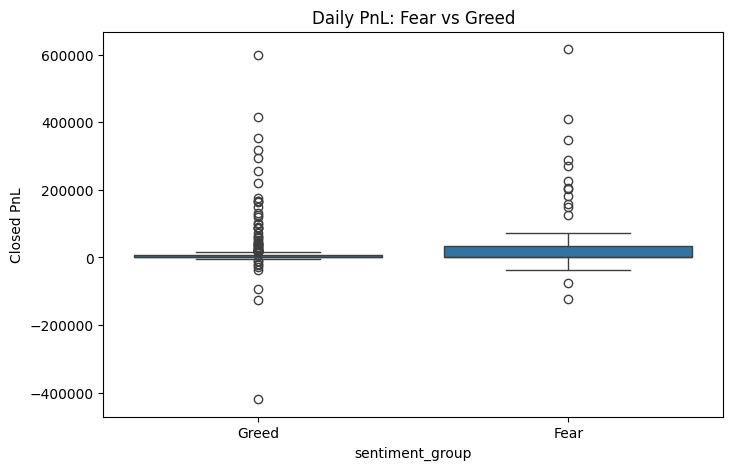

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.boxplot(data=fg_daily,x='sentiment_group',y='Closed PnL')
plt.title("Daily PnL: Fear vs Greed")
plt.show()

In [46]:
daily_trade_counts=(merged_df.groupby(['date','sentiment_group']).size().reset_index(name='num_trades'))
daily_trade_counts.groupby('sentiment_group')['num_trades'].mean()

,num_trades
sentiment_group,
Fear,792.733333
Greed,294.120521
Neutral,562.477612


In [47]:
merged_df.groupby('sentiment_group')['Size USD'].mean()

,Size USD
sentiment_group,
Fear,7182.011019
Greed,4574.424490
Neutral,4782.732661


In [50]:
#Frequent vs Infrequent
median_trades=account_stats['total_trades'].median()
account_stats['freq_segment']=account_stats['total_trades'].apply(
    lambda x:'Frequent' if x>median_trades else 'Infrequent')

In [51]:
#Consistent vs Volatile
median_vol=account_stats['pnl_std'].median()
account_stats['consistency_segment']=account_stats['pnl_std'].apply(
    lambda x: 'Volatile' if x > median_vol else 'Consistent')

In [52]:
#High Exposure vs Low Exposure
median_size=account_stats['avg_size'].median()
account_stats['exposure_segment']=account_stats['avg_size'].apply(
    lambda x: 'High Exposure' if x>median_size else 'Low Exposure')

In [53]:
merged_df=merged_df.merge(account_stats[['freq_segment','consistency_segment','exposure_segment']],left_on='Account',
    right_index=True,how='left')

In [55]:
merged_df.groupby(['freq_segment', 'sentiment_group'])['Closed PnL'].mean()

freq_segment  sentiment_group
Frequent      Fear                47.325875
              Greed               41.476621
              Neutral             34.579701
Infrequent    Fear                61.968833
              Greed              155.896341
              Neutral             31.845656
Name: Closed PnL, dtype: float64

In [56]:
merged_df.groupby(['freq_segment','sentiment_group'])['Closed PnL'].median()

freq_segment  sentiment_group
Frequent      Fear               0.0
              Greed              0.0
              Neutral            0.0
Infrequent    Fear               0.0
              Greed              0.0
              Neutral            0.0
Name: Closed PnL, dtype: float64

In [57]:
merged_df.groupby(['consistency_segment','sentiment_group'])['Closed PnL'].mean()

consistency_segment  sentiment_group
Consistent           Fear                 6.734244
                     Greed               27.548685
                     Neutral              3.493386
Volatile             Fear                90.920235
                     Greed              125.211317
                     Neutral             83.021460
Name: Closed PnL, dtype: float64

In [58]:
merged_df.groupby(['exposure_segment','sentiment_group'])['Closed PnL'].mean()

exposure_segment  sentiment_group
High Exposure     Fear                83.234638
                  Greed              124.932233
                  Neutral             90.484560
Low Exposure      Fear                28.985071
                  Greed               27.826940
                  Neutral              9.008249
Name: Closed PnL, dtype: float64

In [59]:
freq_daily=(merged_df.groupby(['date','freq_segment','sentiment_group'])['Closed PnL'].sum().reset_index())
freq_daily.groupby(['freq_segment','sentiment_group'])['Closed PnL'].mean()

freq_segment  sentiment_group
Frequent      Fear               33978.572875
              Greed              10947.788225
              Neutral            18054.327851
Infrequent    Fear                9101.778490
              Greed              13271.523260
              Neutral             3316.371256
Name: Closed PnL, dtype: float64

# **Insight 1: Sentiment Regime Impacts Aggregate Profitability**

Daily average profitability is highest during Fear regimes and lower during Greed periods.
However, Greed exhibits significantly larger extreme drawdowns.

This indicates:

* Fear environments provide stronger aggregate trading opportunity.
* Greed regimes amplify downside tail risk.
* Market optimism does not necessarily translate to higher aggregate trader profitability.

In [66]:
daily_sentiment_summary=(daily_sentiment_pnl.groupby('sentiment_group')['Closed PnL'].agg(['mean','std','min','max']))
daily_sentiment_summary

,mean,std,min,max
sentiment_group,,,,
Fear,39012.054192,96894.941505,-122672.000883,616413.032233
Greed,15847.884637,66645.098043,-419020.225731,599151.795008
Neutral,19297.323516,37995.209071,-10116.875552,213860.675308


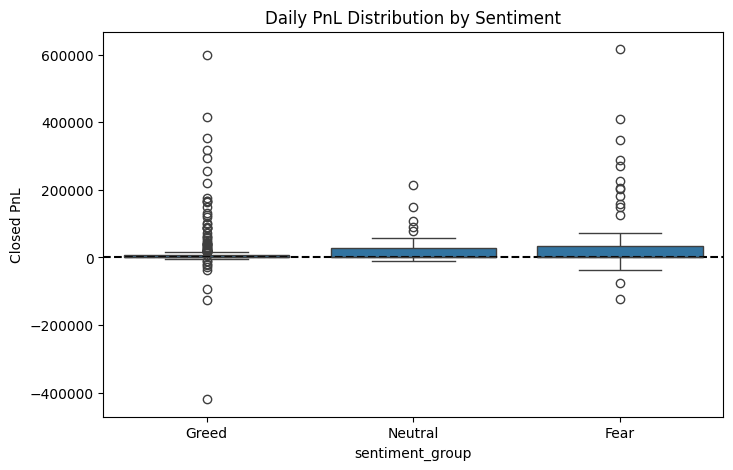

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
sns.boxplot(data=daily_sentiment_pnl,
            x='sentiment_group',
            y='Closed PnL')
plt.title("Daily PnL Distribution by Sentiment")
plt.axhline(0, color='black', linestyle='--')
plt.show()

# **Insight 2: Higher Win Rate During Greed Does Not Mean Higher Profitability**

Win rate is slightly higher during Greed compared to Fear.
However, aggregate daily PnL is lower during Greed.

This suggests:
* Traders win slightly more often during optimistic regimes.
* Loss severity and volatility reduce overall profitability.
* Greed environments may increase overconfidence-driven risk.
This highlights a risk-return asymmetry across sentiment regimes.

In [62]:
win_rate_by_sentiment=(merged_df.groupby('sentiment_group')['win'].mean())
win_rate_by_sentiment

,win
sentiment_group,
Fear,0.407871
Greed,0.420311
Neutral,0.396991


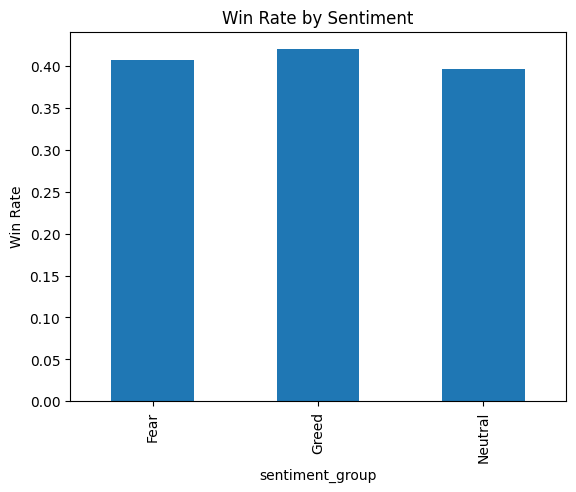

In [63]:
win_rate_by_sentiment.plot(kind='bar')
plt.title("Win Rate by Sentiment")
plt.ylabel("Win Rate")
plt.show()

# **Insight 3: Trading Frequency Interacts with Market Sentiment**

Frequent traders significantly outperform during Fear regimes,
while infrequent traders perform best during Greed regimes.

This suggests:
* Active strategies benefit from volatile, uncertain environments.
* Selective or low-frequency traders benefit more from momentum-driven optimism.
* Sentiment regimes affect trader archetypes differently.

In [64]:
freq_daily_summary=(
    freq_daily
    .groupby(['freq_segment','sentiment_group'])['Closed PnL']
    .mean()
    .unstack())
freq_daily_summary

sentiment_group,Fear,Greed,Neutral
freq_segment,,,
Frequent,33978.572875,10947.788225,18054.327851
Infrequent,9101.778490,13271.523260,3316.371256


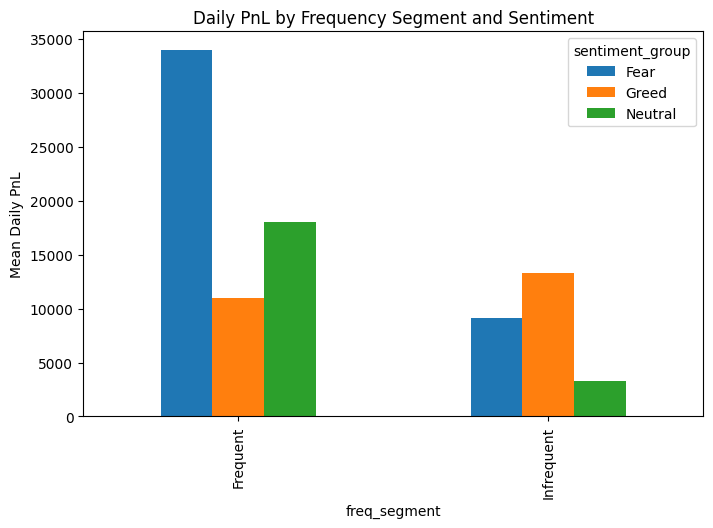

In [65]:
freq_daily_summary.plot(kind='bar', figsize=(8,5))
plt.title("Daily PnL by Frequency Segment and Sentiment")
plt.ylabel("Mean Daily PnL")
plt.show()

# **Insight 4: Position Size Magnifies Sentiment-Driven Outcomes**

High-exposure traders generate substantially higher returns across all regimes,
with the strongest amplification during Greed periods.

This indicates:
* Larger position sizes increase sensitivity to market sentiment.
* Greed regimes particularly reward aggressive exposure.
* However, tail-risk analysis suggests higher exposure may also amplify drawdowns.

In [67]:
exposure_summary=(merged_df.groupby(['exposure_segment','sentiment_group'])['Closed PnL'].mean().unstack())
exposure_summary

sentiment_group,Fear,Greed,Neutral
exposure_segment,,,
High Exposure,83.234638,124.932233,90.484560
Low Exposure,28.985071,27.826940,9.008249


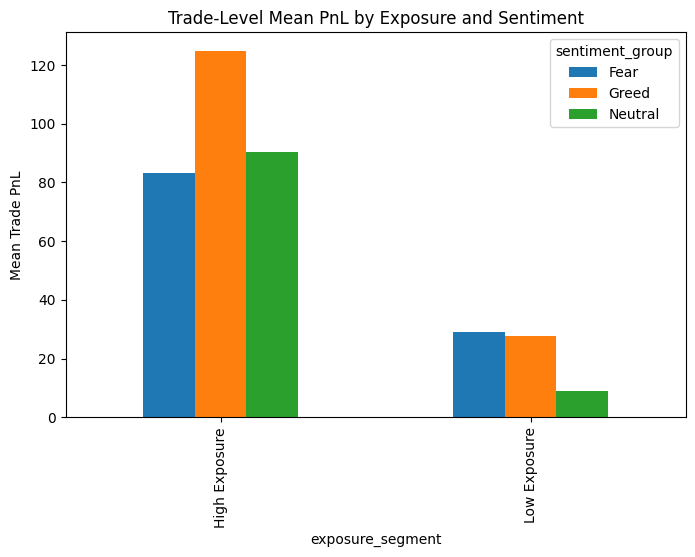

In [69]:
exposure_summary.plot(kind='bar',figsize=(8,5))
plt.title("Trade-Level Mean PnL by Exposure and Sentiment")
plt.ylabel("Mean Trade PnL")
plt.show()

# **Part C) Actionable Output**

# **Strategy Rule 1:** Regime-Adaptive Trading Frequency

**1. Rule**

Increase trade frequency during Fear regimes; reduce activity during Greed regimes unless strategy is momentum-based.

**2. Evidence From Analysis**
* Frequent traders significantly outperform during Fear (≈ 33,978 daily mean PnL).
* Infrequent traders perform better during Greed.
* Daily aggregate profitability is higher during Fear overall.

**3. Rationale**

Fear regimes likely:

* Increase volatility
* Create dislocations
* Offer short-term arbitrage opportunities

Frequent traders appear structurally better suited to exploit these environments.

Conversely:

Greed regimes favor selective participation rather than overtrading.

# **Strategy Rule 2:** Exposure Scaling Based on Sentiment
**1. Rule**

Scale position size cautiously during Greed regimes; allow higher exposure during Fear only with strict risk controls.

**2. Evidence From Analysis**
* High-exposure traders earn substantially more during Greed.
* However, Greed regimes show larger extreme drawdowns.
* Loss asymmetry and volatility increase in Greed periods.

**3. Rationale**

Greed environments amplify both upside and tail risk.

Thus:
* Aggressive exposure can generate strong returns
* But risk of large drawdowns increases

A smarter approach is dynamic exposure sizing:
* Moderate-to-high exposure in Fear (volatility opportunity)
* Controlled, risk-managed exposure in Greed (avoid tail amplification)

# **Strategy Rule 3:**
**1. Rule:**
During Greed regimes, favor momentum-aligned positions and avoid contrarian overexposure.

**2. Evidence:**
* Slightly higher win rate during Greed
* High-exposure traders benefit more
* Increased SELL bias suggests positioning tension

**3. Interpretation:**

Greed periods appear momentum-driven.
Contrarian or over-leveraged strategies may amplify downside tails.

# **Final Summary:**
This analysis demonstrates that market sentiment significantly interacts with trader behavior and profitability. Fear regimes are associated with higher aggregate opportunity for active traders, while Greed regimes amplify exposure-driven outcomes and tail risk. Strategy performance is not uniform across trader archetypes, highlighting the importance of regime-aware behavioral adaptation.